In [487]:
%matplotlib inline

import sys
import random
import timeit
import operator

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

sns.set_context(rc = {'patch.linewidth': 2.0})
sns.set_style("white")
sns.set_palette(sns.color_palette("dark"))
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('seaborn-notebook')

data_dir = '../data/'

In [242]:
df_features = pd.DataFrame.from_csv(data_dir + 'df_features.csv')

print 'Total Data Points:', len(df_features)

df_features.head()

Total Data Points: 44289


,Segment_ID,Segment_Num,Year,Route,County,District,Postmile,Postmile_Boundary,Postmile_Distance,Latitude,...,Ahead_Collisions_Morning_Ratio,Ahead_Collisions_Daytime_Ratio,Ahead_Collisions_Evening_Ratio,Ahead_Collisions_Nighttime_Ratio,Back_Collisions_Rate,Back_Collisions_Per_Distance,Back_Collisions_Morning_Ratio,Back_Collisions_Daytime_Ratio,Back_Collisions_Evening_Ratio,Back_Collisions_Nighttime_Ratio
0,0,1,2010,1,1,12,0.129,8.430,8.301,33.467051,...,0.116667,0.283333,0.383333,0.216667,0.000000,6.866643,0.157895,0.228070,0.456140,0.157895
1,1,4,2010,1,1,12,8.430,9.418,0.988,33.531752,...,0.096154,0.326923,0.480769,0.096154,0.001083,39.473684,0.051282,0.230769,0.512821,0.205128
2,2,5,2010,1,1,12,9.418,19.797,10.379,33.542738,...,0.084746,0.355932,0.457627,0.101695,0.002472,8.575007,0.157303,0.224719,0.483146,0.134831
3,3,11,2010,1,1,12,19.797,21.549,1.752,33.621271,...,0.173913,0.130435,0.434783,0.260870,0.000435,11.415525,0.150000,0.250000,0.400000,0.200000
4,4,13,2010,1,1,12,21.549,22.090,0.541,33.630667,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [488]:
for year in df_features.Year.unique():
    print year, \
        len(df_features[df_features.Year == year]), \
        sum(df_features[df_features.Year == year].Total_Collisions)

2010 4813 134799
2011 5791 135304
2012 5799 137522
2013 6888 146957
2014 6957 126481
2015 6985 106817
2016 7056 0


In [253]:
base_cols = [
    u'Route', u'County', u'District', 
    u'Postmile', u'Postmile_Boundary', u'Postmile_Distance', 
    u'Latitude', u'Longitude',
    u'Ahead_Collisions_Rate', 
    u'Back_Collisions_Rate', 
]

prev_cols = [
    u'Back_Peak_Hourly', u'Back_Peak_Monthly', 
    u'Ahead_Peak_Hourly', u'Ahead_Peak_Monthly', 
    u'Ahead_Collision_Ratio', u'Back_Collision_Ratio',
    u'Ahead_Collision_Spread', u'Back_Collision_Spread',
    u'Ahead_Collisions_Per_Distance',
    u'Ahead_Collisions_Morning_Ratio', u'Ahead_Collisions_Daytime_Ratio',
    u'Ahead_Collisions_Evening_Ratio', u'Ahead_Collisions_Nighttime_Ratio',
    u'Back_Collisions_Per_Distance',
    u'Back_Collisions_Morning_Ratio', u'Back_Collisions_Daytime_Ratio',
    u'Back_Collisions_Evening_Ratio', u'Back_Collisions_Nighttime_Ratio',    
]

unused_cols = [
    u'Segment_ID', u'Segment_Num', u'Year', 
    u'Back_AADT', u'Ahead_AADT',
    u'Ahead_Collisions', u'Back_Collisions', u'Total_Collisions',
    u'Ahead_Collisions_Morning', u'Ahead_Collisions_Daytime',
    u'Ahead_Collisions_Evening', u'Ahead_Collisions_Nighttime',
    u'Back_Collisions_Morning', u'Back_Collisions_Daytime',
    u'Back_Collisions_Evening', u'Back_Collisions_Nighttime',
]

pred_col = u'%s_Collisions_Rate'

In [254]:
df_pred = {}

for year in range(2011, 2015):
    df_pred[year] = df_features[(df_features.Year == year)
                               & (df_features.Segment_Num > 0)][['Segment_Num'] + base_cols]
    
    df_prev = df_features[(df_features.Year == (year - 1))][['Segment_Num'] + prev_cols]
        
    df_prev.columns = ('Previous_' + df_prev.columns[1:]).insert(0, 'Segment_Num')
    
    df_pred[year] = pd.merge(df_pred[year], df_prev, on='Segment_Num')

In [255]:
df_pred[2014].head()

,Segment_Num,Route,County,District,Postmile,Postmile_Boundary,Postmile_Distance,Latitude,Longitude,Ahead_Collisions_Rate,...,Previous_Ahead_Collisions_Per_Distance,Previous_Ahead_Collisions_Morning_Ratio,Previous_Ahead_Collisions_Daytime_Ratio,Previous_Ahead_Collisions_Evening_Ratio,Previous_Ahead_Collisions_Nighttime_Ratio,Previous_Back_Collisions_Per_Distance,Previous_Back_Collisions_Morning_Ratio,Previous_Back_Collisions_Daytime_Ratio,Previous_Back_Collisions_Evening_Ratio,Previous_Back_Collisions_Nighttime_Ratio
0,1,1,1,12,0.129,0.780,0.651,33.467051,-117.669910,0.000160,...,12.288786,0.000000,0.500000,0.500000,0.000000,3.072197,0.000000,0.000000,0.500000,0.500000
1,2,1,1,12,0.780,4.864,4.084,33.464190,-117.678921,0.000026,...,0.489716,0.500000,0.500000,0.000000,0.000000,0.244858,0.000000,0.000000,1.000000,0.000000
2,4,1,1,12,8.430,9.418,0.988,33.531752,-117.774864,0.000916,...,33.400810,0.181818,0.393939,0.272727,0.151515,24.291498,0.125000,0.375000,0.416667,0.083333
3,5,1,1,12,9.418,9.600,0.182,33.542738,-117.785319,0.000181,...,65.934066,0.166667,0.416667,0.250000,0.166667,21.978022,0.000000,0.500000,0.500000,0.000000
4,6,1,1,12,9.600,11.500,1.900,33.543890,-117.788323,0.000373,...,8.947368,0.176471,0.235294,0.352941,0.235294,5.789474,0.090909,0.545455,0.363636,0.000000


In [251]:
pred_year = 2014

df_train = df_features[df_features.Year <  pred_year]
df_test  = df_features[df_features.Year == pred_year]

print 'Train: %5d, Test: %5d' % (len(df_train), len(df_test))

Train: 23291, Test:  6957


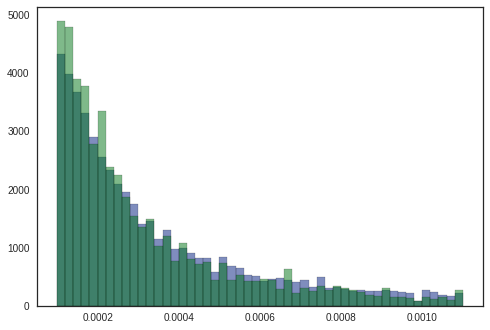

In [278]:
for df in [df_train, df_test]:
    plt.hist(
        df.Ahead_Collisions_Rate, 
        normed=True, bins=50, alpha=0.5, range=(0.0001, 0.0011)
    );

In [291]:
print 'fit_cols = ['
for col in df_train.columns:
    print "'%s'," % col
print ']'

fit_cols = [
'Segment_ID',
'Segment_Num',
'Year',
'Route',
'County',
'District',
'Postmile',
'Postmile_Boundary',
'Postmile_Distance',
'Latitude',
'Longitude',
'Back_Peak_Hourly',
'Back_Peak_Monthly',
'Back_AADT',
'Ahead_Peak_Hourly',
'Ahead_Peak_Monthly',
'Ahead_AADT',
'Ahead_Collisions',
'Back_Collisions',
'Total_Collisions',
'Ahead_Collisions_Morning',
'Ahead_Collisions_Daytime',
'Ahead_Collisions_Evening',
'Ahead_Collisions_Nighttime',
'Back_Collisions_Morning',
'Back_Collisions_Daytime',
'Back_Collisions_Evening',
'Back_Collisions_Nighttime',
'Ahead_Collision_Ratio',
'Back_Collision_Ratio',
'Ahead_Collision_Spread',
'Back_Collision_Spread',
'Ahead_Collisions_Rate',
'Ahead_Collisions_Per_Distance',
'Ahead_Collisions_Morning_Ratio',
'Ahead_Collisions_Daytime_Ratio',
'Ahead_Collisions_Evening_Ratio',
'Ahead_Collisions_Nighttime_Ratio',
'Back_Collisions_Rate',
'Back_Collisions_Per_Distance',
'Back_Collisions_Morning_Ratio',
'Back_Collisions_Daytime_Ratio',
'Back_Collisions_Evening_Rat

In [467]:
base_cols = [
# 'Year',
# 'Route',
# 'County',
# 'District',
'Postmile',
'Postmile_Distance',
'Latitude',
'Longitude',
]

prev_cols = [
'Ahead_Peak_Hourly',
'Ahead_Peak_Monthly',
'Ahead_Collision_Ratio',
'Ahead_Collision_Spread',
'Ahead_Collisions_Per_Distance',
'Ahead_Collisions_Morning_Ratio',
'Ahead_Collisions_Daytime_Ratio',
'Ahead_Collisions_Evening_Ratio',
'Ahead_Collisions_Nighttime_Ratio',
    
'Back_Peak_Hourly',
'Back_Peak_Monthly',
'Back_Collision_Ratio',
'Back_Collision_Spread',
'Back_Collisions_Per_Distance',
'Back_Collisions_Morning_Ratio',
'Back_Collisions_Daytime_Ratio',
'Back_Collisions_Evening_Ratio',
'Back_Collisions_Nighttime_Ratio',
]
fit_cols = base_cols + ['Previous_%s' % c for c in prev_cols]

In [ ]:
holdout_split=0.2
random_seed=4

X_train, X_eval = train_test_split(
    df_train, 
    test_size = holdout_split, 
    random_state = random_seed
)

In [479]:
model = XGBRegressor(
    max_depth=6,
    learning_rate=0.01,
#     gamma=1,
    subsample=0.6,
    colsample_bytree=0.8,
#     reg_alpha=0.1,
    reg_lambda=1,
    random_state=4,
    n_estimators=2000
)

model.fit(
    X_train[fit_cols], X_train[pred_col],
    eval_set=[(X_eval[fit_cols], X_eval[pred_col])],
    eval_metric='rmse', verbose=False,
    early_stopping_rounds=100
)

print 'Best Iteration: %d of 1000' % model.best_iteration

print 'Sum of Squares: %-.4f' % model.score(X_eval[fit_cols], X_eval[pred_col])

feature_list = zip(fit_cols, model.feature_importances_)

for col, val in sorted(feature_list, key = operator.itemgetter(1), reverse = True):
    print '%50s:   %.3f' % (col, val)

Best Iteration: 945 of 1000
Sum of Squares: 0.6643
                                 Postmile_Distance:   0.142
                       Previous_Ahead_Peak_Monthly:   0.126
                        Previous_Ahead_Peak_Hourly:   0.091
            Previous_Ahead_Collisions_Per_Distance:   0.076
                                          Postmile:   0.063
                   Previous_Ahead_Collision_Spread:   0.061
                                          Latitude:   0.052
             Previous_Back_Collisions_Per_Distance:   0.047
                                         Longitude:   0.045
                    Previous_Back_Collision_Spread:   0.042
                    Previous_Ahead_Collision_Ratio:   0.036
                        Previous_Back_Peak_Monthly:   0.032
                         Previous_Back_Peak_Hourly:   0.030
         Previous_Ahead_Collisions_Nighttime_Ratio:   0.025
           Previous_Ahead_Collisions_Daytime_Ratio:   0.025
           Previous_Ahead_Collisions_Evening_Rati

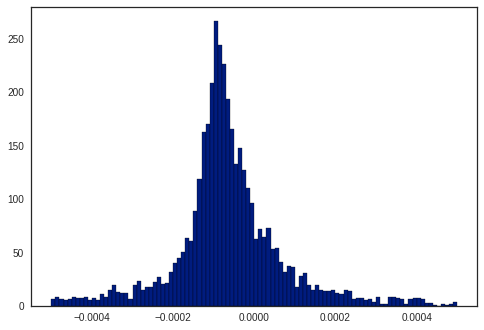

In [486]:
df_test['Pred_%s' % pred_col] = model.predict(df_test[fit_cols])
df_test['Pred_Diff'] = df_test.Ahead_Collisions_Rate - df_test.Pred_Ahead_Collisions_Rate

df_plot = df_test[df_test.Ahead_Collisions_Rate > 0]

plt.hist(df_plot.Pred_Diff, bins=100, range=(-0.0005, 0.0005));

In [ ]:
df_test.to_csv(data_dir + 'df_predict_v1.0.csv')